# Import all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Part I: Data and Feature-engineering

### Working on Dataset

In [2]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

print(data.head())

data['tokenized_text'] = data['comment_text'].apply(word_tokenize)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


### Term Frequency-Inverse Document Frequency transformation

In [3]:
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(data['comment_text']).toarray()

### Segerating data into training and testing sets

In [4]:
y = data.drop(columns=['id', 'comment_text', 'tokenized_text'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Bar graph of Trained label frequency

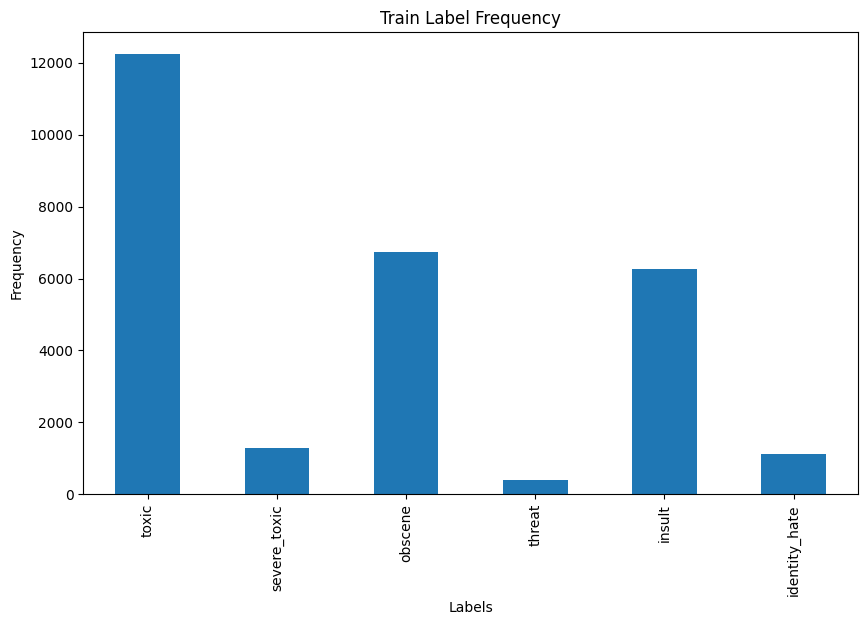

In [5]:
train_label_counts = y_train.sum()
plt.figure(figsize=(10, 6))
train_label_counts.plot(kind='bar')
plt.title('Train Label Frequency')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

### Correlation matrix for train label set

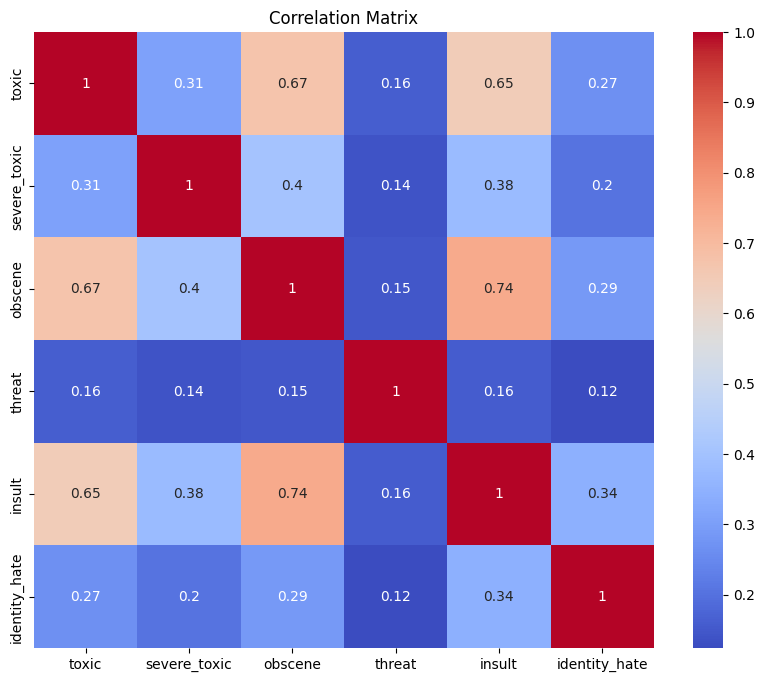

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(y_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Pairwise label correlations to visualize relationship between toxicity categories

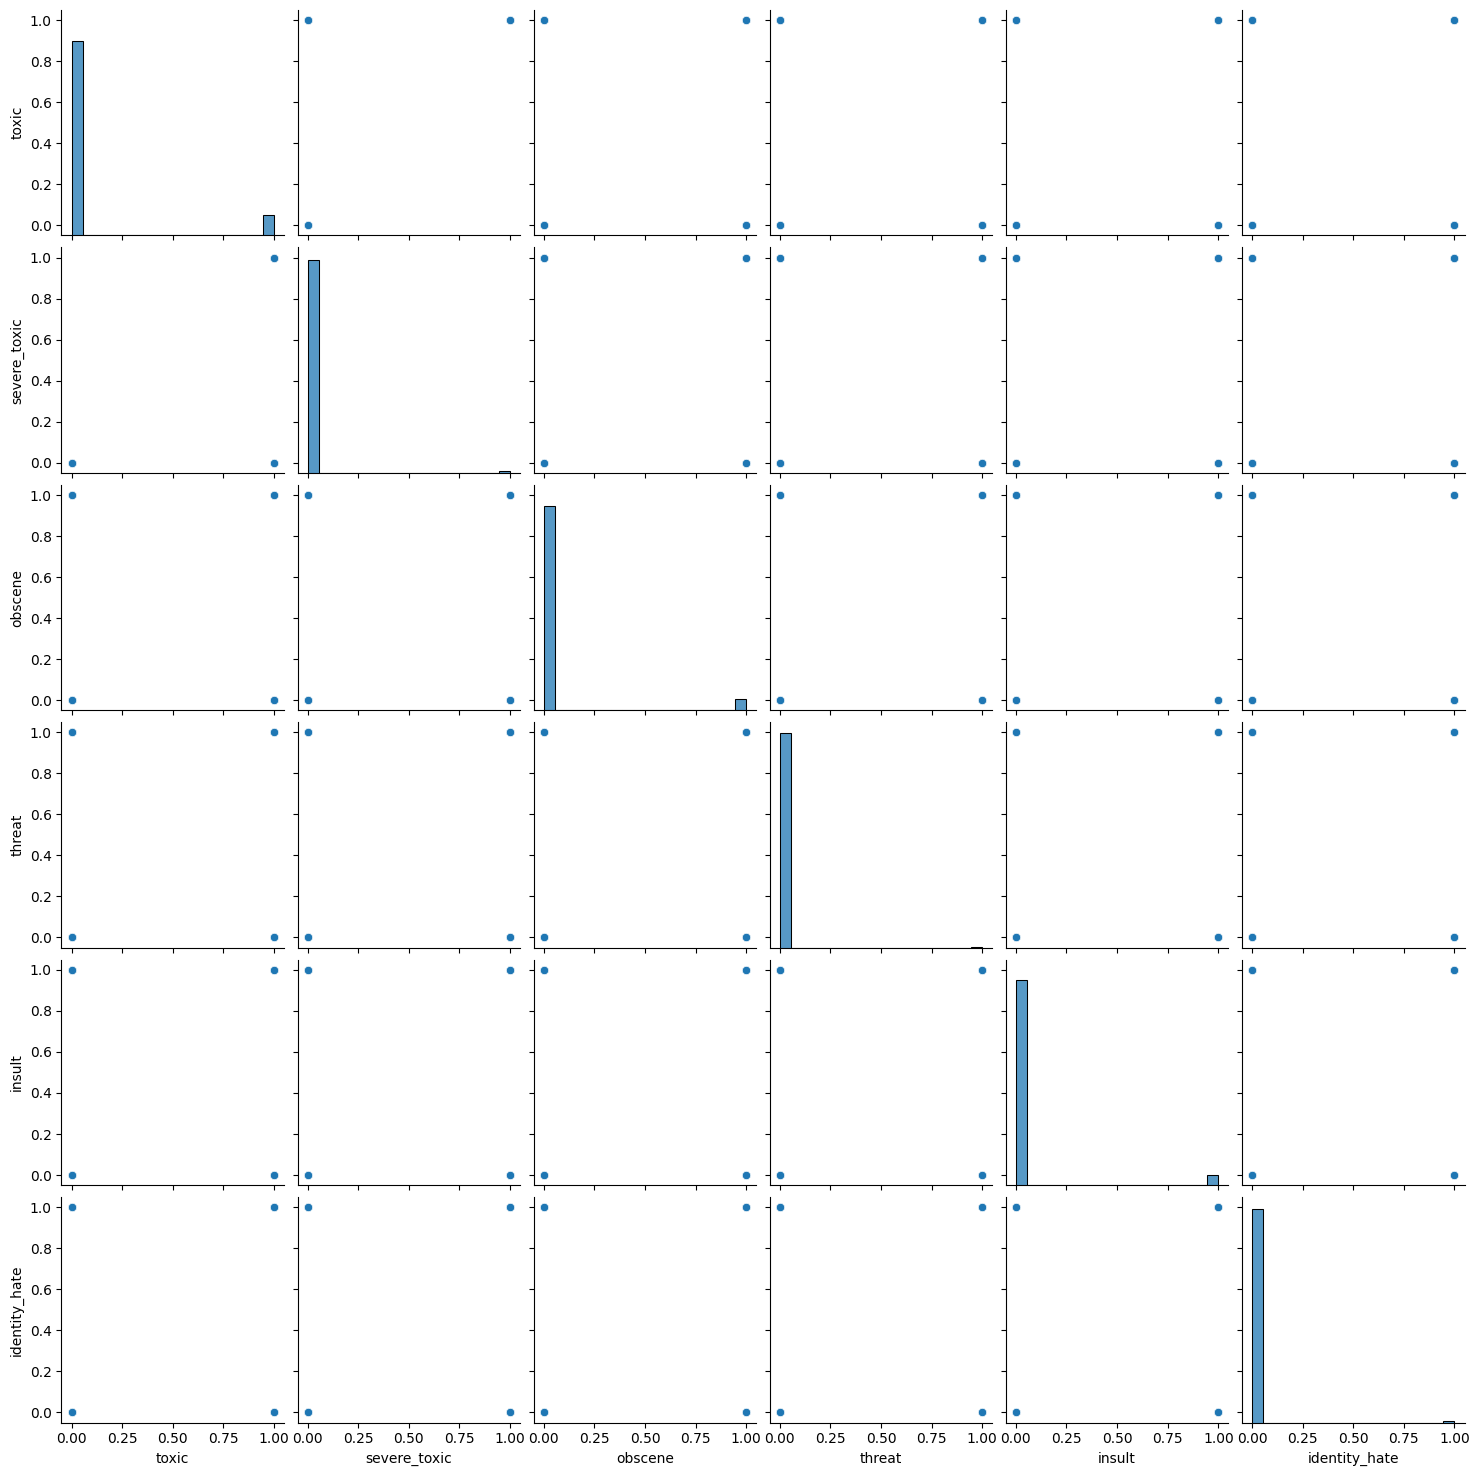

In [7]:
sns.pairplot(y_train)
plt.show()

# Part II: Modeling and Evaluation

### Setting label as toxic

In [8]:
y_toxic_train = y_train['toxic']
y_toxic_test = y_test['toxic']

### Models

In [9]:
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVC': LinearSVC()
}

### Training and evaluate models

Multinomial Naive Bayes Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28859
           1       0.93      0.50      0.65      3056

    accuracy                           0.95     31915
   macro avg       0.94      0.75      0.81     31915
weighted avg       0.95      0.95      0.94     31915



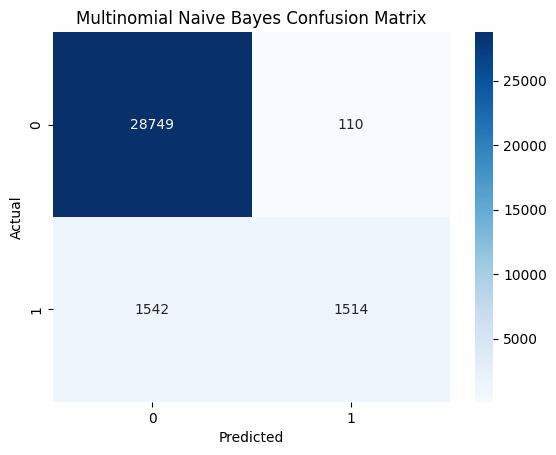

Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.91      0.62      0.74      3056

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.96      0.96      0.95     31915



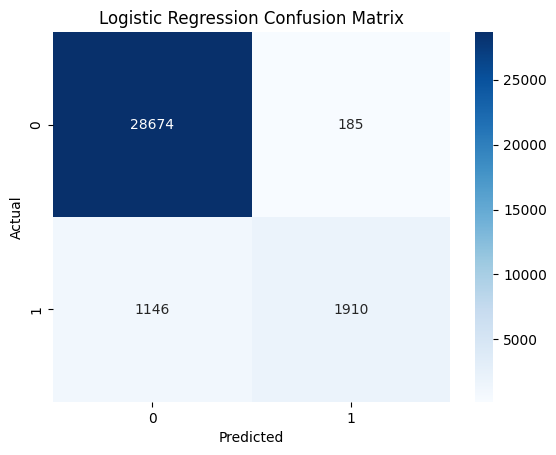

Linear SVC Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28859
           1       0.88      0.70      0.78      3056

    accuracy                           0.96     31915
   macro avg       0.92      0.84      0.88     31915
weighted avg       0.96      0.96      0.96     31915



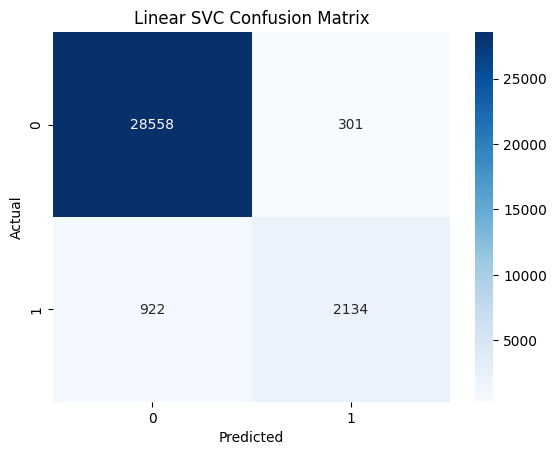

In [10]:
model_accuracies = []
for name, model in models.items():
    model.fit(X_train, y_toxic_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_toxic_test, y_pred)
    model_accuracies.append((name, accuracy))
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_toxic_test, y_pred))
    cm = confusion_matrix(y_toxic_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Voting Classifier

In [11]:
voting_clf = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='hard')
voting_clf.fit(X_train, y_toxic_train)
y_pred_voting = voting_clf.predict(X_test)
voting_accuracy = accuracy_score(y_toxic_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.2f}")

Voting Classifier Accuracy: 0.96


### Ploting accuracy comparison between models

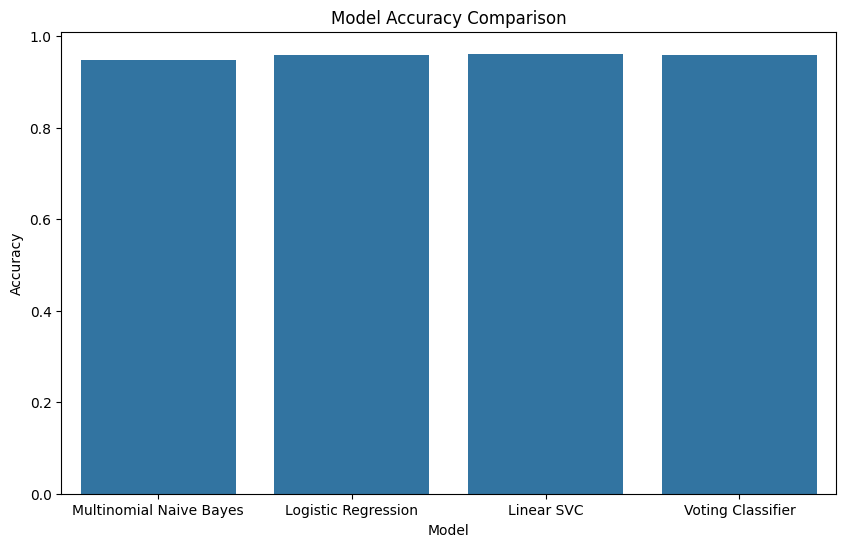

In [12]:
model_accuracies.append(('Voting Classifier', voting_accuracy))
model_accuracies = pd.DataFrame(model_accuracies, columns=['Model', 'Accuracy'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=model_accuracies)
plt.title('Model Accuracy Comparison')
plt.show()

# Part III: LSTM

### Tokenizer and padding

In [13]:
max_words = 10000
max_sequence_length = 10
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['comment_text'])
X_seq = tokenizer.texts_to_sequences(data['comment_text'])
X_padded = pad_sequences(X_seq, maxlen=max_sequence_length)
X_padded = np.array(X_padded)

### LSTM model

In [14]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

y_toxic = y['toxic'].values

model.fit(X_padded, y_toxic, epochs=5, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9360 - loss: 0.2020 - val_accuracy: 0.9490 - val_loss: 0.1578
Epoch 2/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9515 - loss: 0.1401 - val_accuracy: 0.9480 - val_loss: 0.1651
Epoch 3/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.9582 - loss: 0.1159 - val_accuracy: 0.9464 - val_loss: 0.1733
Epoch 4/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9620 - loss: 0.1012 - val_accuracy: 0.9434 - val_loss: 0.1878
Epoch 5/5
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9688 - loss: 0.0840 - val_accuracy: 0.9416 - val_loss: 0.2161


### Testing toxicity with custom comments

In [16]:
custom_comments = ["You are an perpetrator", "I hate you very much", "You're very good", "What the hell is this?", "I love and admire you"]
custom_seq = tokenizer.texts_to_sequences(custom_comments)
custom_padded = pad_sequences(custom_seq, maxlen=max_sequence_length)
predictions = model.predict(custom_padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


### Printing custom comments with toxicity probabilities

In [17]:
for comment, prob in zip(custom_comments, predictions):
    print(f"Comment: {comment}\nToxicity Probability: {prob[0]:.2f}\n")

Comment: You are an perpetrator
Toxicity Probability: 0.69

Comment: I hate you very much
Toxicity Probability: 0.47

Comment: You're very good
Toxicity Probability: 0.03

Comment: What the hell is this?
Toxicity Probability: 0.57

Comment: I love and admire you
Toxicity Probability: 0.00



In [18]:
model.save('lstm_model.h5')
# I saved the model using .h5 as given in the example, but I made this code first in python, so I was throwing an waring in terminal that .h5 is legacy and it was not looking good so I changed it to keras.